In [2]:
import pandas as pd
#import sketch
import plotly.graph_objects as go
from collections import Counter
from plotly.subplots import make_subplots
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
import string
import spacy
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
#!python3 -m spacy download en_core_web_sm
import pyLDAvis.gensim_models
import gensim
from gensim import corpora

[nltk_data] Downloading package punkt to /Users/mintee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv('../../data/raw/reviews.csv')
df.head()

Sentiment     Time                                               Text
0  positive  18/6/21  This is a very healthy dog food. Good for thei...
1  positive   7/7/21  I've been very pleased with the Natural Balanc...
2  positive  18/6/21  Before I was educated about feline nutrition, ...
3  positive   7/7/21  My holistic vet recommended this, along with a...
4  positive   1/7/21  I bought this coffee because its much cheaper ...

## Sentiment distribution

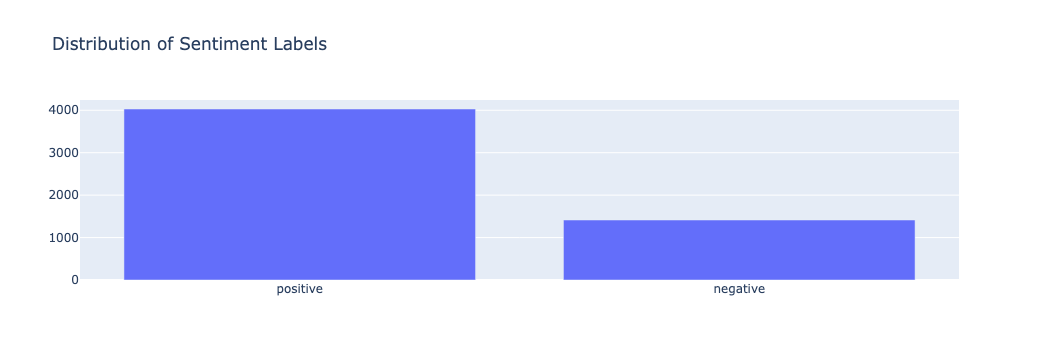

In [4]:
# Count the number of reviews for each sentiment
sentiment_counts = df['Sentiment'].value_counts()
data = go.Bar(x=sentiment_counts.index, y=sentiment_counts.values)
layout = go.Layout(title='Distribution of Sentiment Labels')
fig = go.Figure(data=data, layout=layout)
fig.show()

As shown, the data set is slightly imbalanced with 4030 positve sentiments and 1414 negative sentiments

## Recency of the data

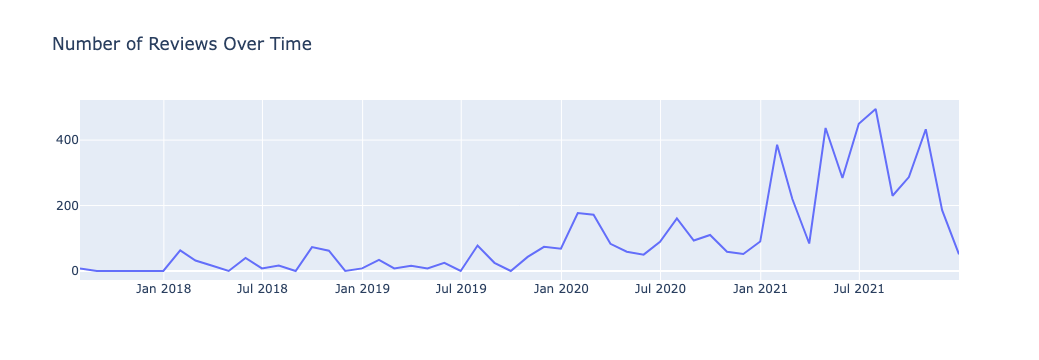

In [5]:
df['Time'] = pd.to_datetime(df['Time'])
reviews_by_date = df.groupby(pd.Grouper(key='Time', freq='M')).size()

data = go.Scatter(x=reviews_by_date.index, y=reviews_by_date.values, mode='lines')
layout = go.Layout(title='Number of Reviews Over Time')
fig = go.Figure(data=data, layout=layout)
fig.show()

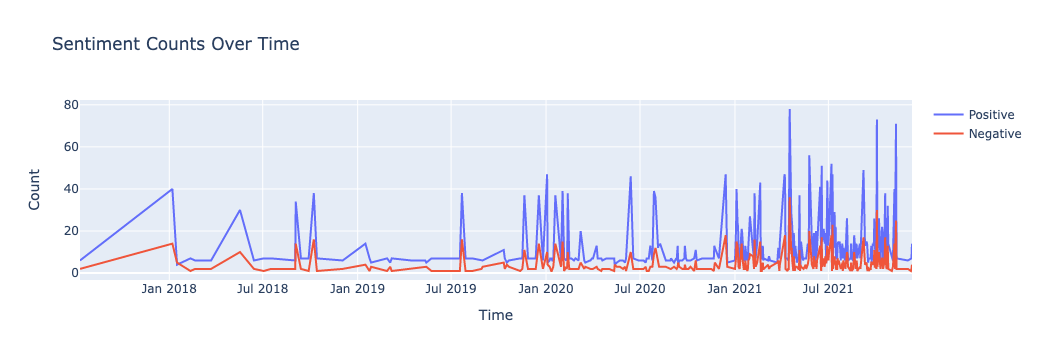

In [6]:
sentiment_counts = df.groupby(['Time', 'Sentiment']).size().reset_index(name='count')

fig = go.Figure()
fig.add_trace(go.Scatter(x=sentiment_counts[sentiment_counts['Sentiment'] == 'positive']['Time'], 
                         y=sentiment_counts[sentiment_counts['Sentiment'] == 'positive']['count'], 
                         mode='lines', name='Positive'))

fig.add_trace(go.Scatter(x=sentiment_counts[sentiment_counts['Sentiment'] == 'negative']['Time'], 
                         y=sentiment_counts[sentiment_counts['Sentiment'] == 'negative']['count'], 
                         mode='lines', name='Negative'))
fig.update_layout(title='Sentiment Counts Over Time', xaxis_title='Time', yaxis_title='Count')
fig.show()

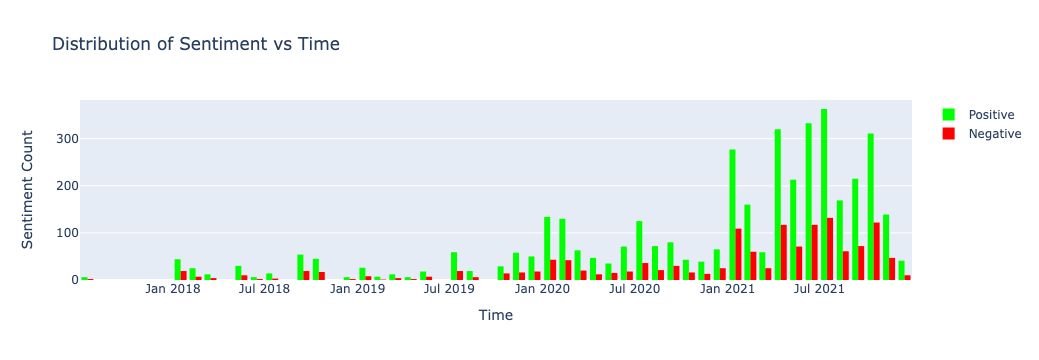

In [7]:
positive_trace = go.Histogram(x=df[df['Sentiment'] == 'positive']['Time'], 
                              name='Positive', 
                              marker_color='#00FF00')
negative_trace = go.Histogram(x=df[df['Sentiment'] == 'negative']['Time'], 
                              name='Negative', 
                              marker_color='#FF0000')
fig = go.Figure()
fig.add_trace(positive_trace)
fig.add_trace(negative_trace)
fig.update_layout(title='Distribution of Sentiment vs Time', xaxis_title='Time', yaxis_title='Sentiment Count')
fig.show()

## Exploring reviews columns

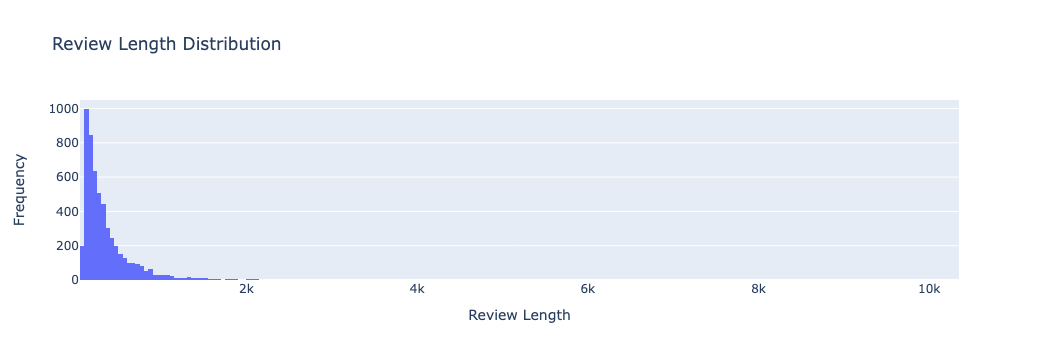

In [8]:
df['review_length'] = df['Text'].apply(len)
fig = go.Figure(data=[go.Histogram(x=df['review_length'])])
fig.update_layout(
    title="Review Length Distribution",
    xaxis_title="Review Length",
    yaxis_title="Frequency"
)
fig.show()

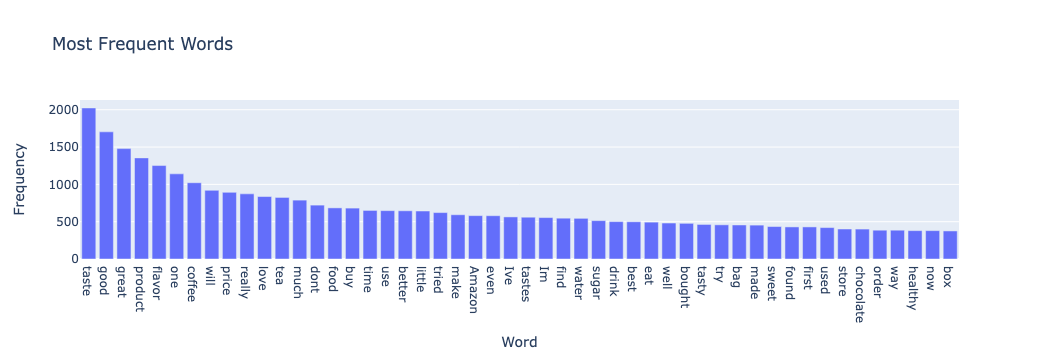

In [9]:
reviews_text = " ".join(df['Text'])
# remove <br> tags from the text
reviews_text = re.sub(r'<br\s?\/?>', ' ', reviews_text)
# remove punctuation from the text
reviews_text = reviews_text.translate(str.maketrans('', '', string.punctuation))
# remove stop words from the text
sw = set(STOPWORDS)
words = [w for w in reviews_text.split() if w.lower() not in sw]

word_counts = Counter(words).most_common(50)
fig = go.Figure([go.Bar(x=[w[0] for w in word_counts], y=[w[1] for w in word_counts])])
fig.update_layout(title="Most Frequent Words", xaxis_title="Word", yaxis_title="Frequency")
fig.show()

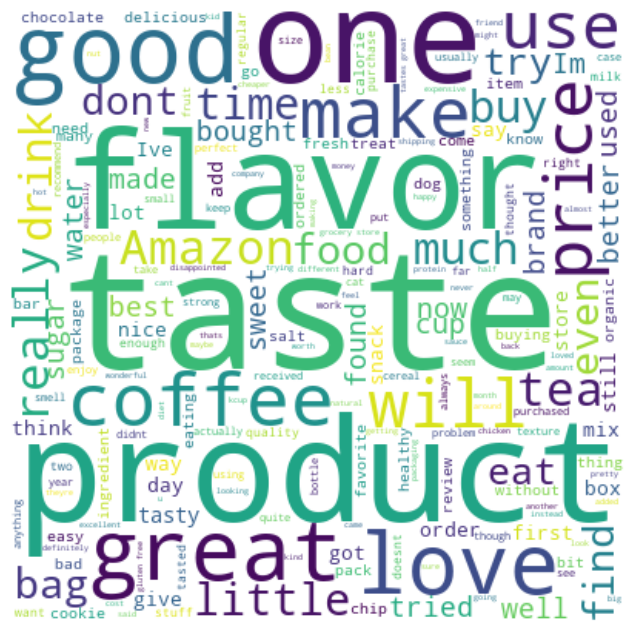

In [10]:
%%capture --no-display
# create a wordcloud of the most frequent words
wordcloud = WordCloud(width=400, height=400, background_color="white", stopwords=sw).generate(reviews_text)
fig = plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

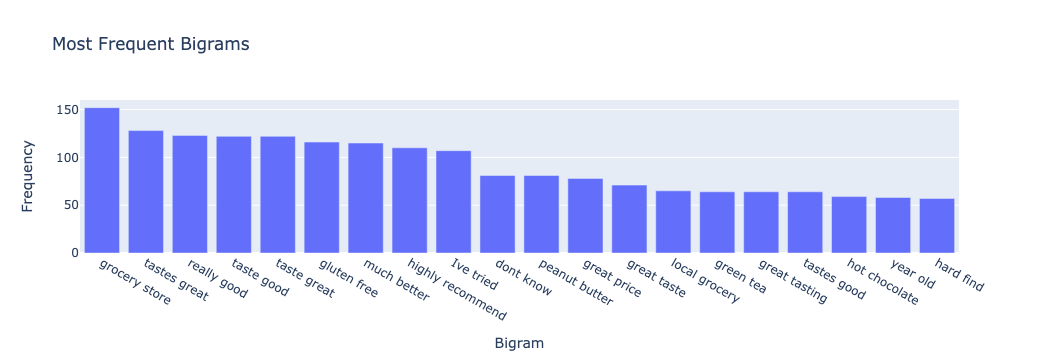

In [11]:
# get the most frequent bigrams and their counts, filtering out those that contain stop words
bigrams = [b for b in zip(words[:-1], words[1:]) if b[0].lower() not in sw and b[1].lower() not in sw]
bigram_counts = Counter(bigrams).most_common(20)
fig = go.Figure([go.Bar(x=[" ".join(b) for b in [w[0] for w in bigram_counts]], y=[w[1] for w in bigram_counts])])
fig.update_layout(title="Most Frequent Bigrams", xaxis_title="Bigram", yaxis_title="Frequency")
fig.show()

Conclusion:
- Amazon dataset 
- Mainly f&b/grocery products reviewing taste and quality of a product
- Coffee, tea, peanut butter, hot chocolate are some of the products
- More Positive sentiments than negative sentiments (products doing fairly well)
- Date range of data is from 2017-2021 but the number of reviews really exploded in 2020-2021 (Relation with Covid and online shopping?)

## Identify product genre

### Clean data

In [12]:
# define a function to clean the text data
def clean_text(text):
    # remove <br> tags
    text = re.sub(r'<br\s?\/?>', ' ', text)
    # expand contractions
    expanded_text = []
    for word in text.split():
      expanded_text.append(contractions.fix(word))  
    expanded_text = ' '.join(expanded_text)
    # make all words lower case
    expanded_text = expanded_text.lower()
    # remove punctuation
    expanded_text = expanded_text.translate(str.maketrans('', '', string.punctuation))
    # remove stopwords
    stopwords_list = stopwords.words('english')
    stopwords_list.extend(['from', 'subject', 're', 'edu', 'use'])
    words_clean = [word for word in expanded_text.split() if word.lower() not in stopwords_list]
    return " ".join(words_clean)

In [13]:
df['clean_reviews'] = df['Text'].apply(clean_text)
df['clean_review_length'] = df['clean_reviews'].apply(len)
df.head()

Sentiment       Time                                               Text  \
0  positive 2021-06-18  This is a very healthy dog food. Good for thei...   
1  positive 2021-07-07  I've been very pleased with the Natural Balanc...   
2  positive 2021-06-18  Before I was educated about feline nutrition, ...   
3  positive 2021-07-07  My holistic vet recommended this, along with a...   
4  positive 2021-01-07  I bought this coffee because its much cheaper ...   

   review_length                                      clean_reviews  \
0            137  healthy dog food good digestion also good smal...   
1            350  pleased natural balance dog food dogs issues d...   
2            733  educated feline nutrition allowed cats become ...   
3            493  holistic vet recommended along brands tried ca...   
4            413  bought coffee much cheaper ganocafe organic re...   

   clean_review_length  
0                   94  
1                  218  
2                  508  
3                  276  
4                  218

In [14]:
#df.to_csv('../../data/clean/cleaned_reviews.csv')

### LSA

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(df['clean_reviews'])

X.shape # check shape of the document-term matrix

In [ ]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

In [ ]:
terms = vectorizer.get_feature_names_out()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    sentence = ""
    print(sorted_terms)
    # for t in sorted_terms:
    #     print(t[0])

### LDA (1) using sklearn

In [ ]:
# create a CountVectorizer object
vectorizer = CountVectorizer(max_df=0.95, min_df=2)

# fit and transform the clean text data
X = vectorizer.fit_transform(df['clean_reviews'])

# Materialize the sparse data
data_dense = X.todense()

# Compute Sparsicity 
# Sparsicity is the percentage of non-zero datapoints in X
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

# create an LDA object and fit the data
lda = LatentDirichletAllocation(n_components=20, random_state=42)
lda.fit(X)

# print the top 20 words in each topic
feature_names = sorted(vectorizer.vocabulary_.keys())
topic_list = []
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    topic_complete = (", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))
    print(topic_complete)
    topic_list.append(topic_complete)

In [ ]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(X))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(X))

# See model parameters
pprint(lda.get_params())

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good.
On a different note, perplexity might not be the best measure to evaluate topic models because it doesn’t consider the context and semantic associations between words.

In [ ]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint

In [ ]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(X)

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X))

In [ ]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

### LDA (2) using gensim

In [ ]:
# create a list of tokenized reviews without stop words
tokenized_reviews = []
stop_words = set(stopwords.words('english'))
for review in df['clean_reviews']:
    tokens = word_tokenize(review)
    tokens_without_stopwords = [token.lower() for token in tokens if token.lower() not in stop_words]
    tokenized_reviews.append(tokens_without_stopwords)

# create the id2word dictionary
id2word = corpora.Dictionary(tokenized_reviews)

# create the corpus
corpus = [id2word.doc2bow(tokens) for tokens in tokenized_reviews]

# create the LDA model
num_topics = 10
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=10)

# visualize the topics using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

### NER (Named Entity Recognition)

In [ ]:
nlp = spacy.load("en_core_web_sm")

#### Pet products

In [ ]:
def extract_pet_entities(text):
    doc = nlp(text)
    pet_entities = []
    for entity in doc.ents:
        if entity.label_ == "ANIMAL" or "pet" in entity.text.lower() or "dog" in entity.text.lower() or "cat" in entity.text.lower():
            pet_entities.append(entity.text)
    return pet_entities

# apply the extract_pet_entities function to the reviews column
df['pet_entities'] = df['clean_reviews'].apply(extract_pet_entities)

# print the unique pet-related entities that were extracted
pet_entities = set([entity for row in df['pet_entities'] for entity in row])
print(pet_entities)

In [ ]:
print(len(pet_entities))

In [ ]:
df.drop(['pet_entities'], inplace = True, axis = 1)

In [ ]:
def extract_product_entities(text):
    doc = nlp(text)
    product_entities = []
    for entity in doc.ents:
        if entity.label_ == "PRODUCT" or "coffee" in entity.text.lower() or "tea" in entity.text.lower() or "caffeine" in entity.text.lower():
            product_entities.append(entity.text)
    return product_entities


Next steps:
- Explore the brand these reviews are for
- Try to pin down the exact company
- Knowing the domain that this dataset is for, use transfer learning to build a relevant pre-trained model to improve.